# Lab 4

## Author: Konstantin Yakovlev

### Description:
Visualize Evidence similar to slide 7 from the MDL lecture. The visualization must show the dependence between complexity and hidden layer number. Model: 1-layer neural network. Dataset: sklearn dataset. Use normal distribution with scalar covariance prior. For posterior distribution use Laplace approximation.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.autograd.functional import hessian

from sklearn.datasets import load_diabetes
from dataclasses import dataclass
from typing import Tuple

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Laplace approximation

See the derivation of  the following approximation here [BIC](https://github.com/intsystems/BMM/blob/main-22/student_talks/week_3_bic/main.pdf).
$$
\log(\mathbf{X}|M_i) \approx \log p(\mathbf{X}|\theta) + \log p(\theta) + \frac{1}{2}(|\theta|(\log 2\pi - \log n) - 
\log |I_\theta|).
$$

MDL says that:

$$
L(f, D) = L(f) + L(D|\theta, f) + L(\theta|f),
$$
where $\theta$ are parameters of model $f$.

After grouping the terms we get:

$$
L(f) = -\frac{1}{2}(|\theta|(\log 2\pi - \log n))
$$

$$
L(D|\theta, f) = -\log p(\mathbf{X}|\theta)
$$

$$
L(\theta|f) = -\log p(\theta) + \frac{1}{2}\log|I_\theta|
$$


### Global config

In [2]:
@dataclass
class Config:
    # prior and data
    sigma_prior: float = 0.01  # prior variance of network weights
    input_size: int = 10  # the number of features of the data
    data_size: int = 442  # the number of samples in the data
    sigma_likelihood: float = 1  # the variance parameter of the likelihood
    
    # experiment params
    hidden_list: Tuple[int] = (1, 2, 5, 10)  # considered network hidden sizes
    
    # optim
    lr: float = 1e-3
    batch_size: int = 16
    n_epochs: int = 50

config = Config()

### Loading and scaling the data

In [3]:
X, Y = load_diabetes(return_X_y=True)
Y = (Y - Y.mean()) / Y.std()
X = (X - X.mean()) / X.std()

### Creating datasets and dataloaders

In [4]:
ds = TensorDataset(torch.tensor(X).float(), torch.tensor(Y).float())
dl = DataLoader(ds, batch_size=config.batch_size, shuffle=True)

### The MLP model

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_size: int = 5):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm1d(config.input_size),
            nn.Linear(config.input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    
    def forward(self, x: torch.Tensor):
        return self.net(x)
    
    def vectorize_params(self) -> torch.Tensor:
        """Returns a vector of params"""
        return torch.cat([p.reshape(-1) for p in self.parameters()])
    
    def min_log_likeli(self, x, y) -> torch.Tensor:
        """Implements mini-batch approximation of -log p(Y|X, theta)"""
        return ((self(x) - y) ** 2 / (2 * config.sigma_likelihood ** 2)).sum() * config.data_size / config.batch_size
    
    def min_log_prior(self) -> torch.Tensor:
        """Implements -log p(theta)"""
        return 1 / (2 * config.sigma_prior ** 2) * (self.vectorize_params() ** 2).sum()
    
    def loss(self, x, y) -> torch.Tensor:
        """Computes mini-batch approximation of -log p(Y|X, theta) - log p(theta)"""
        return self.min_log_likeli(x, y) + self.min_log_prior()
        
    def model_length(self) -> int:
        """Computes the number of model parameters"""
        return sum([p.numel() for p in self.parameters()])
    
    def model_grad(self) -> torch.Tensor:
        """Returns the accumulated gradient w.r.t. model parameters"""
        return torch.cat([p.grad.reshape(-1) for p in self.parameters()])
    
    def get_log_det(self, x, y) -> torch.Tensor:
        """Computes a mini-batch approximation of log det Fisher matrix"""
        accum_sequare_grad = torch.zeros(self.model_length())
        for p in self.parameters():
            p.grad = torch.zeros_like(p)
        for i in range(x.shape[0]):
            self.min_log_likeli(x[i][None], y[i][None]).backward()
            accum_sequare_grad += self.model_grad() ** 2
        
        accum_sequare_grad += 1 / config.sigma_prior ** 2
        return torch.log(accum_sequare_grad).sum()


In [6]:
### TEST
mlp = MLP(5)
x = torch.rand(3, 10)
mlp(x).shape
mlp.loss(x, torch.randint(2, size=(3,))), mlp.model_length()

(tensor(62557.5039, grad_fn=<AddBackward0>), 81)

In [7]:
def train_model(model):
    """Performs a training loop"""
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=config.lr)

    losses = []

    for _ in range(config.n_epochs):
        for batch in dl:
            x, y = batch
            opt.zero_grad()
            loss = model.loss(x, y)
            losses.append(loss.item())
            loss.backward()
            opt.step()
            
    return losses


### Train the models

In [8]:
report = {
    'lengths': [],
    'log_dets': [],
    'min_log_likeli': [],
    'min_log_prior': [],
}
losses_arr = []

X_tensor = torch.stack([el[0] for el in ds])
y_tensor = torch.stack([el[1] for el in ds])

for hidden_size in config.hidden_list:
    model = MLP(hidden_size=hidden_size)
    report['lengths'].append(model.model_length())
    losses = train_model(model)
    losses_arr.append(losses)
    model.eval()
    report['log_dets'].append(model.get_log_det(X_tensor, y_tensor).detach().cpu().numpy())
    report['min_log_likeli'].append(model.min_log_likeli(X_tensor, y_tensor).detach().cpu().numpy())
    report['min_log_prior'].append(model.min_log_prior().detach().cpu().numpy())
    

### Visualize training
Make sure that all models have successfully converged

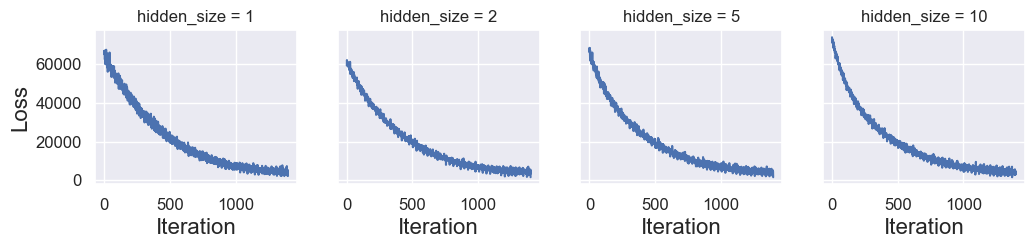

In [9]:
fig, axs = plt.subplots(1, len(config.hidden_list), figsize=(12, 2), sharey=True)
for i in range(len(config.hidden_list)):
    axs[i].plot(losses_arr[i])
    axs[i].set_xlabel('Iteration')
    axs[i].set_title(f'hidden_size = {config.hidden_list[i]}')
axs[0].set_ylabel('Loss')
plt.show()

In [10]:
def l_f(length: int):
    """Computes L(f) term"""
    return -0.5 * length * (np.log(2 * np.pi) - np.log(config.data_size))

def l_d_f(min_log_likeli):
    """Computes L(d|f) term"""
    return min_log_likeli

def l_theta_f(min_log_prior, log_det_fisher):
    """Computes L(theta|f) term"""
    return min_log_prior + 1/2 * log_det_fisher

In [11]:
final_report = {'l_f': [], 'l_d_f': [], 'l_theta_f': []}

for i in range(len(report['lengths'])):
    final_report['l_f'].append(l_f(report['lengths'][i]))
    final_report['l_d_f'].append(l_d_f(report['min_log_likeli'][i]))
    final_report['l_theta_f'].append(l_theta_f(report['min_log_prior'][i], report['log_dets'][i]))
    
for key in final_report:
    final_report[key] = np.array(final_report[key]).astype(np.float32)
    final_report[key] /= final_report[key].max()

### Final visualization

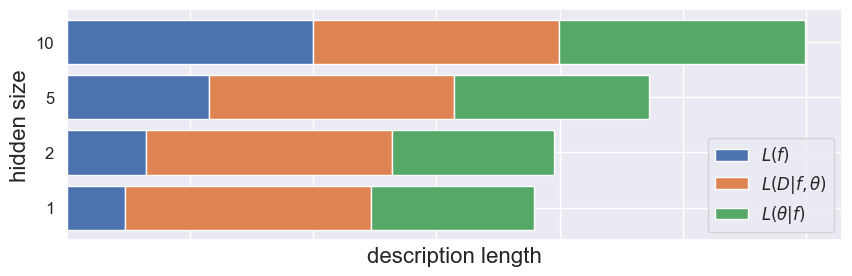

In [12]:
plt.figure(figsize=(10, 3))

plt.tick_params(labelbottom = False, bottom = False)

vis_mapping = {'l_f': r'$L(f)$', 'l_d_f': r'$L(D|f, \theta)$', 'l_theta_f': r'$L(\theta|f)$'}

values = np.zeros_like(report['lengths']).astype(np.float32)
for key in final_report:
    plt.barh([str(l) for l in config.hidden_list], final_report[key], label=vis_mapping[key], left=values)
    values += final_report[key]
plt.legend()
plt.xlabel('description length')
plt.ylabel('hidden size')
plt.show()

### Conclusion

As we can see from the diagram, a neural network with only one neuron in the hidden layer has the
shortest description lengths. This suggests that such simple MLP are over-parametrized.